In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from generateData import *

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Initialization of DATA

In [4]:
n = 3 #Input dimension
o = 3 #Output dimension

In [5]:
N = 1000
dim = n
Ntrain = 0.9
noisy = False
M = 2
T = 1
x_train, y_train, x_test, y_test, h = generate(N,M,T,Ntrain,noisy)

Time step:  1.0


In [6]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float64))
    self.y = torch.from_numpy(y.astype(np.float64))
    self.length = self.x.shape[0]

  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]
  def __len__(self):
    return self.length #num elementi del dataset

batch_size = 32

trainset = dataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = dataset(x_test,y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

## Structure preserving approach

In [7]:
import torch.nn.functional as F

class DynamicBlock(nn.Module):
    def __init__(self, nlayer, input, lift):
        super(DynamicBlock, self).__init__()
        
        self.nlayers = nlayer
        self.input = input
        self.lift = lift
        self.DOF = int(self.input * (self.input-1) / 2)

        self.A = nn.ModuleList([nn.Linear(self.input,self.lift,bias=False) for i in range(self.nlayers)])
        self.B = nn.ModuleList([nn.Linear(self.lift,self.DOF) for i in range(self.nlayers)])
        self.Biases = nn.ParameterList([nn.Parameter(torch.randn(self.lift)) for i in range(self.nlayers)])
        self.nl = nn.ReLU()

        self.dts = nn.Parameter(torch.randn(self.nlayers))

        self.alpha = torch.ones(self.input)

    def buildSkew(self,ff):
        res = torch.zeros((len(ff),self.input,self.input))
        iu1 = torch.triu_indices(self.input,self.input,1)
        res[:,iu1[0],iu1[1]] = ff
        res = res - torch.transpose(res,1,2)
        return res

    def forward(self, x):
        
        for i in range(self.nlayers):
            c = self.A[i](x)+self.Biases[i]
            ff = self.nl(self.B[i](self.nl(self.A[i](x)+self.Biases[i])))
            Mat = self.buildSkew(ff)
            x = x + self.dts[i] * self.alpha @ Mat
        return x

#Linear lifting layer that preserves the sum
class Lift(nn.Module):
    def __init__(self, lift):
        super(Lift, self).__init__()
        self.outputDim = lift
    def forward(self,x):
        I = torch.eye(x.shape[1])
        Z = torch.zeros((x.shape[1],self.outputDim-x.shape[1]))
        liftMat = torch.cat((I,Z),dim=1)
        return x@liftMat

#Projection layer that preserves the sum
class Projection(nn.Module):
    def __init__(self, inputDim, lowerDim):
        super(Projection, self).__init__()
        self.outputDim = lowerDim
        self.input = inputDim
    def forward(self,x):
        I = torch.eye(self.outputDim)
        Z = torch.zeros((self.input-self.outputDim,self.outputDim))
        projMat = torch.cat((I,Z),dim=0)
        s = torch.sum(x[:,self.outputDim:],dim=1).unsqueeze(1)/(self.outputDim)
        y = x @ projMat
        y = y + s
        return y        

class Network(nn.Module):
    def __init__(self, input, output):
        super(Network, self).__init__()
        
        self.input = input
        self.output = output
        dim = [3,10,10,15]
        lift = max(dim)
        lista = []
        for i in np.arange(1,len(dim)):
            if dim[i]>dim[i-1]:
                lista.append(Lift(dim[i]))
            else:
                lista.append(Projection(dim[i-1],dim[i]))
                
            #lista.append(DynamicBlock(3,dim[i],max(dim)))
            lista.append(DynamicBlock(3,dim[i],50))

        lista.append(Projection(dim[-1],o))
        self.seq = nn.Sequential(*lista)

    def forward(self, x):
        x = self.seq(x)
        return x

net = Network(n, o)

In [8]:
import torch.optim as optim

criterion = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1)

In [9]:
checkpoint = 5
epochs = 150

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, outputs = data[0], data[1]
        optimizer.zero_grad()
        loss = 0
        for k in range(M-1):
          inputs = net(inputs)
          loss += criterion(inputs,outputs[:,:,k])

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % checkpoint == 0:  
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / checkpoint))
            running_loss = 0.0

    scheduler.step()
    if epoch%20 == 0 and epoch>0:
      lr=optimizer.param_groups[0]["lr"]
      print(f"\n\nLR: {lr}, EPOCH: {epoch}\n\n")
    
    #scheduler.step()

print('Finished Training')

[1,     1] loss: 2.492594
[1,     6] loss: 5.955685
[1,    11] loss: 0.290312
[1,    16] loss: 0.053156
[1,    21] loss: 0.023740
[1,    26] loss: 0.008369
[2,     1] loss: 0.000559
[2,     6] loss: 0.003131
[2,    11] loss: 0.002014
[2,    16] loss: 0.001819
[2,    21] loss: 0.000972
[2,    26] loss: 0.000718
[3,     1] loss: 0.000175
[3,     6] loss: 0.000742
[3,    11] loss: 0.000403
[3,    16] loss: 0.000324
[3,    21] loss: 0.000323
[3,    26] loss: 0.000283
[4,     1] loss: 0.000047
[4,     6] loss: 0.000425
[4,    11] loss: 0.000179
[4,    16] loss: 0.000110
[4,    21] loss: 0.000076
[4,    26] loss: 0.000384
[5,     1] loss: 0.000122
[5,     6] loss: 0.000269
[5,    11] loss: 0.000257
[5,    16] loss: 0.000113
[5,    21] loss: 0.000101
[5,    26] loss: 0.001112
[6,     1] loss: 0.000998
[6,     6] loss: 0.002446
[6,    11] loss: 0.003517
[6,    16] loss: 0.004427
[6,    21] loss: 0.012141
[6,    26] loss: 0.004227
[7,     1] loss: 0.000754
[7,     6] loss: 0.001641
[7,    11] l

In [10]:
net.eval();

In [11]:
data = next(iter(testloader))
input, output = data[0], data[1]
predSol = torch.zeros((len(input),dim,M-1))
predSol[:,:,0] = net(input)
for i in range(1,M-1):
    predSol[:,:,i] = net(predSol[:,:,i-1])
print("Test error: ",criterion(predSol,output))
print("Sum first output: ",torch.sum(net(input[0:1])))
print("Sum first input: ",torch.sum(input[0:1]))

Test error:  tensor(3.3460e-06, grad_fn=<MseLossBackward0>)
Sum first output:  tensor(1.0000, grad_fn=<SumBackward0>)
Sum first input:  tensor(1.)


# Evaluation

In [12]:
NN = 10
y0 = np.random.rand(NN,dim)
y0 = y0/np.sum(y0,axis=1).reshape(-1,1)
time = np.linspace(0,T,M)

In [13]:
def flowC(y):
    z = torch.from_numpy(y.astype(np.float64))
    return net(z).detach().numpy()

In [14]:
R0 = 1
f = lambda t,y: np.array([-R0*y[0]*y[1],
                            R0*y[0]*y[1] - y[1],
                            y[1]
    ])

In [15]:
sol_true = np.zeros((NN,dim,M))
sol_predC = np.zeros((NN,dim,M))
#sol_predU = np.zeros((NN,6,M))

sol_true[:,:,0] = y0
sol_predC[:,:,0] = y0
#sol_predU[:,:,0] = y0

for i in range(NN):
    sol_true[i] = scipy.integrate.solve_ivp(f,[0,T],y0[i],method='RK45',t_eval=time,atol=1e-11,rtol=1e-11).y
for i in range(M-1):
    sol_predC[:,:,i+1] = flowC(sol_predC[:,:,i]) 

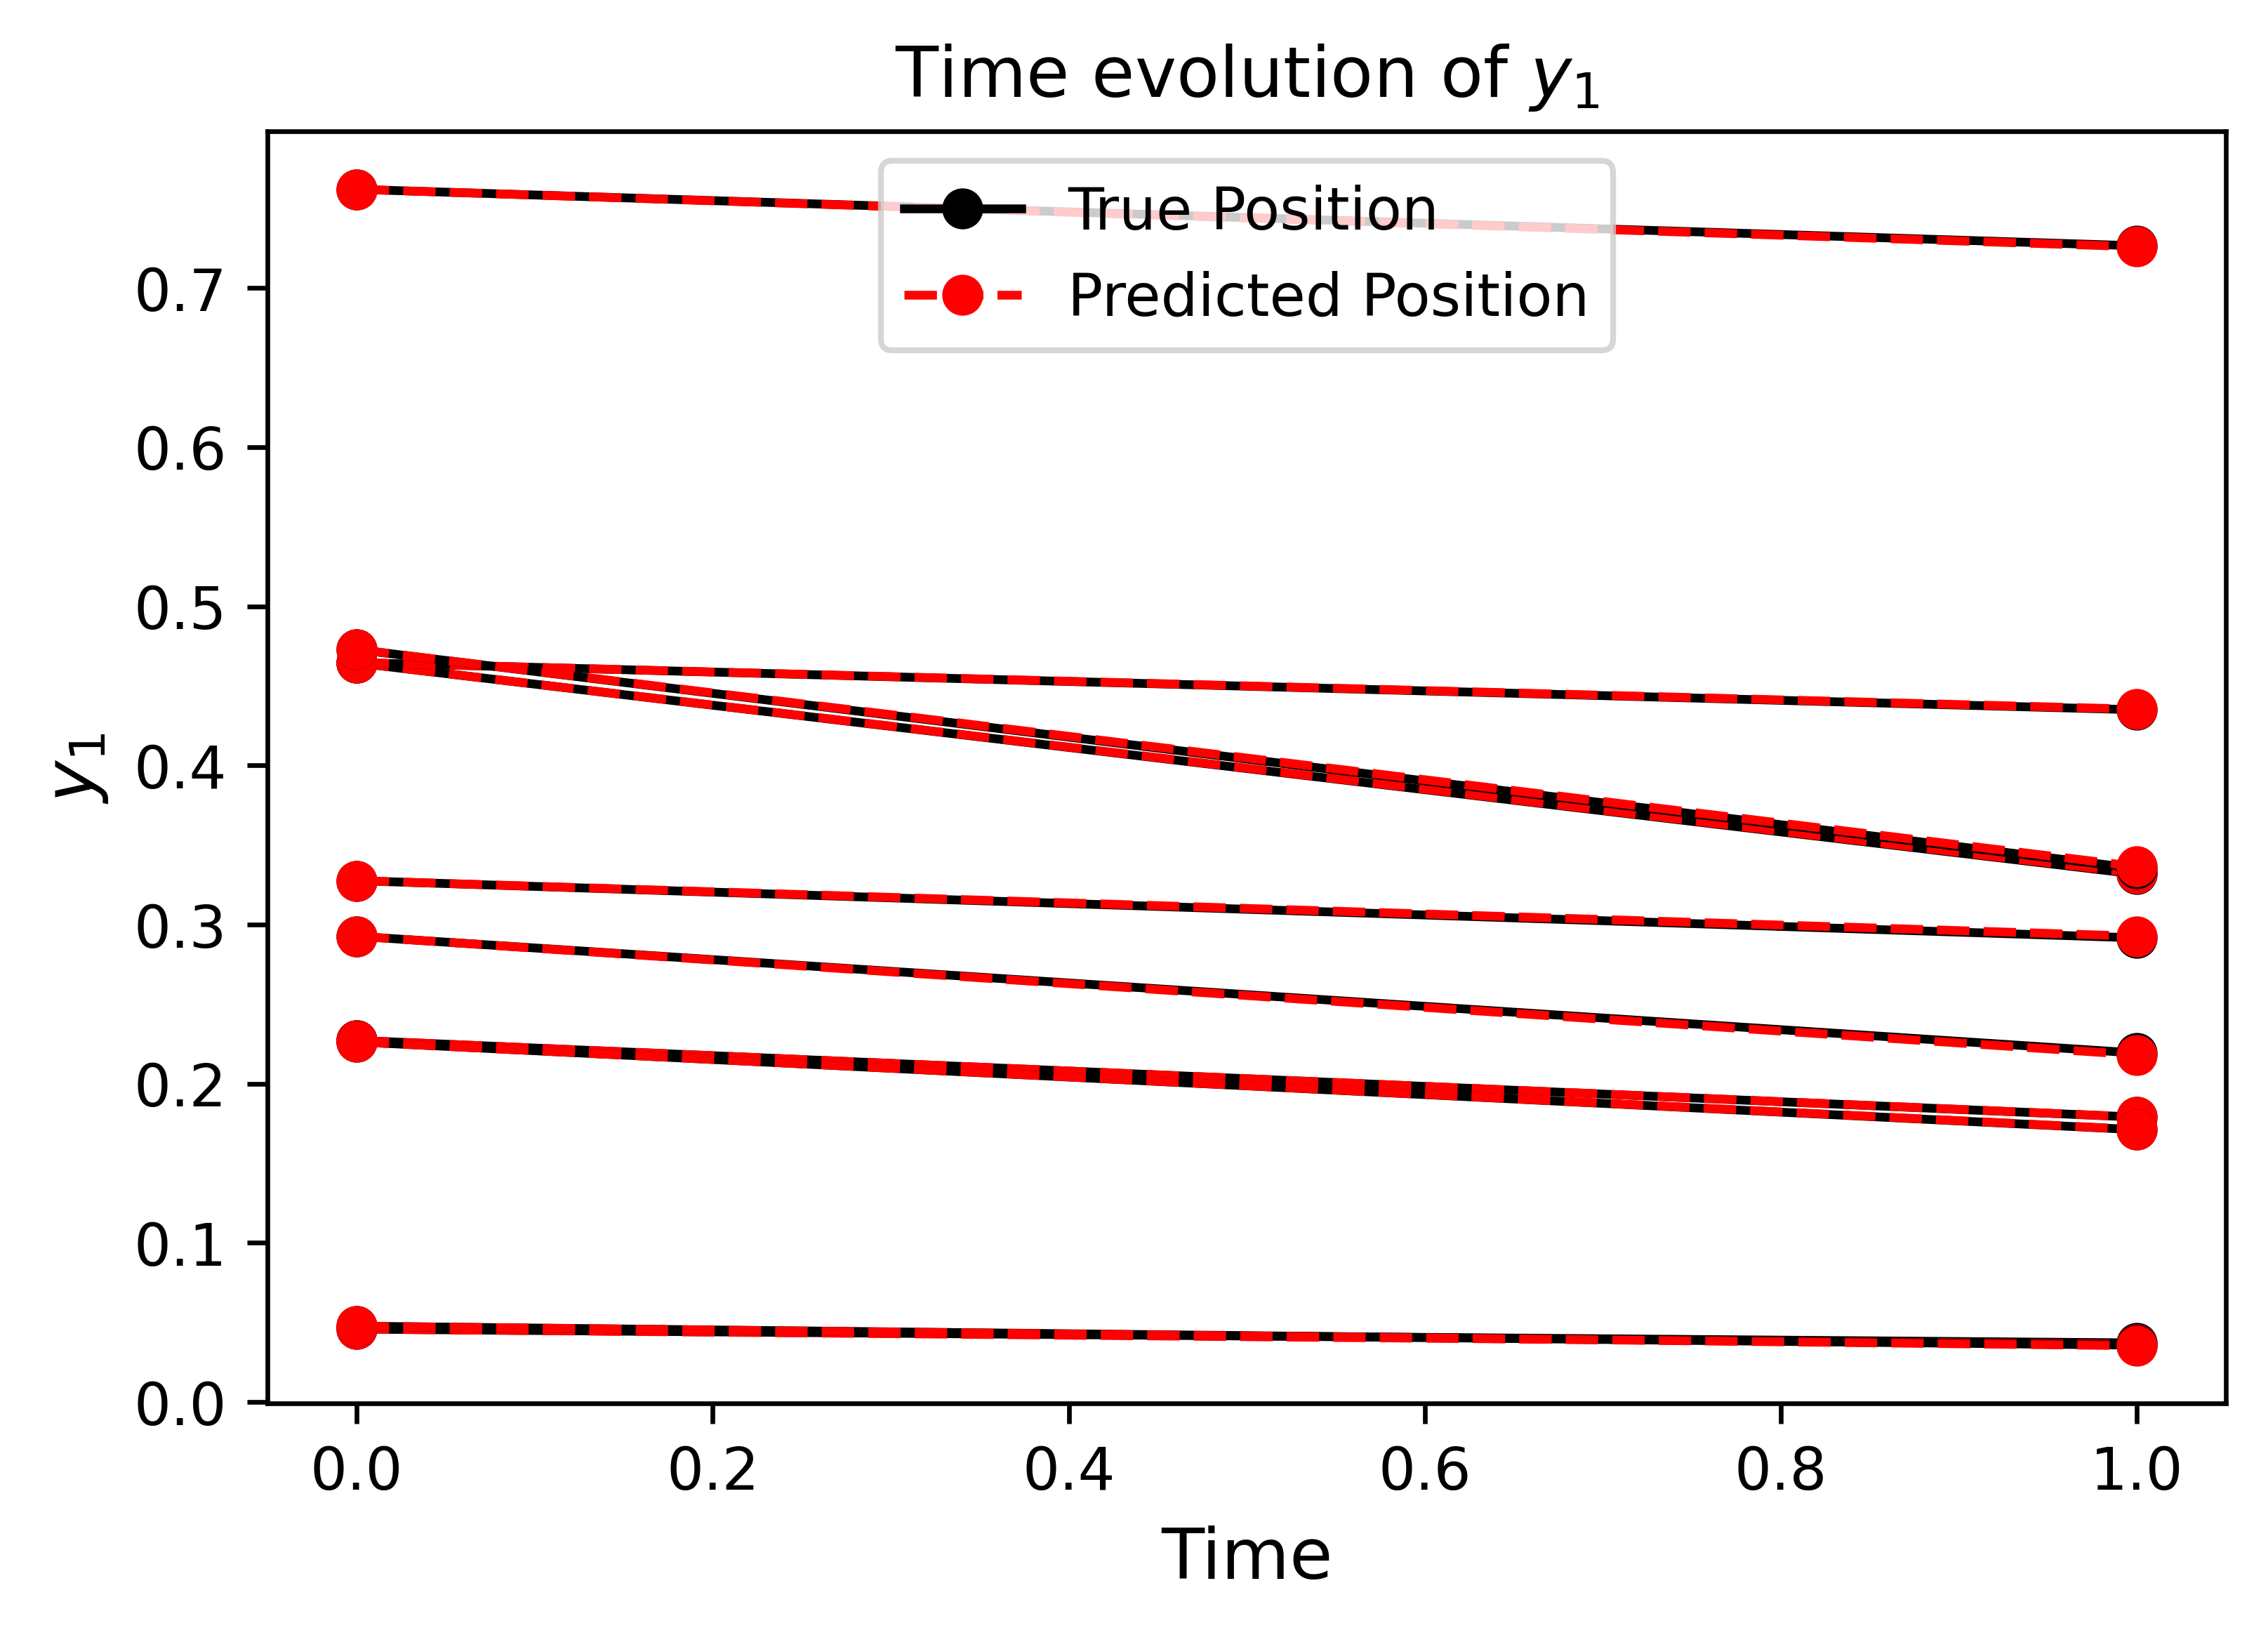

In [22]:
fig = plt.figure(dpi=600)
plt.plot(time[0],sol_true[0,0,0],'k-o',label='True Position')
plt.plot(time[0],sol_predC[0,0,0],'r--o',label='Predicted Position')
for i in range(NN):
    plt.plot(time,sol_true[i,0,:],'k-o')
    plt.plot(time,sol_predC[i,0,:],'r--o')
plt.xlabel("Time",fontsize=12)
plt.ylabel(r"$y_1$",fontsize=12)
plt.legend()
plt.title(r"Time evolution of $y_1$",fontsize=12)
plt.show();

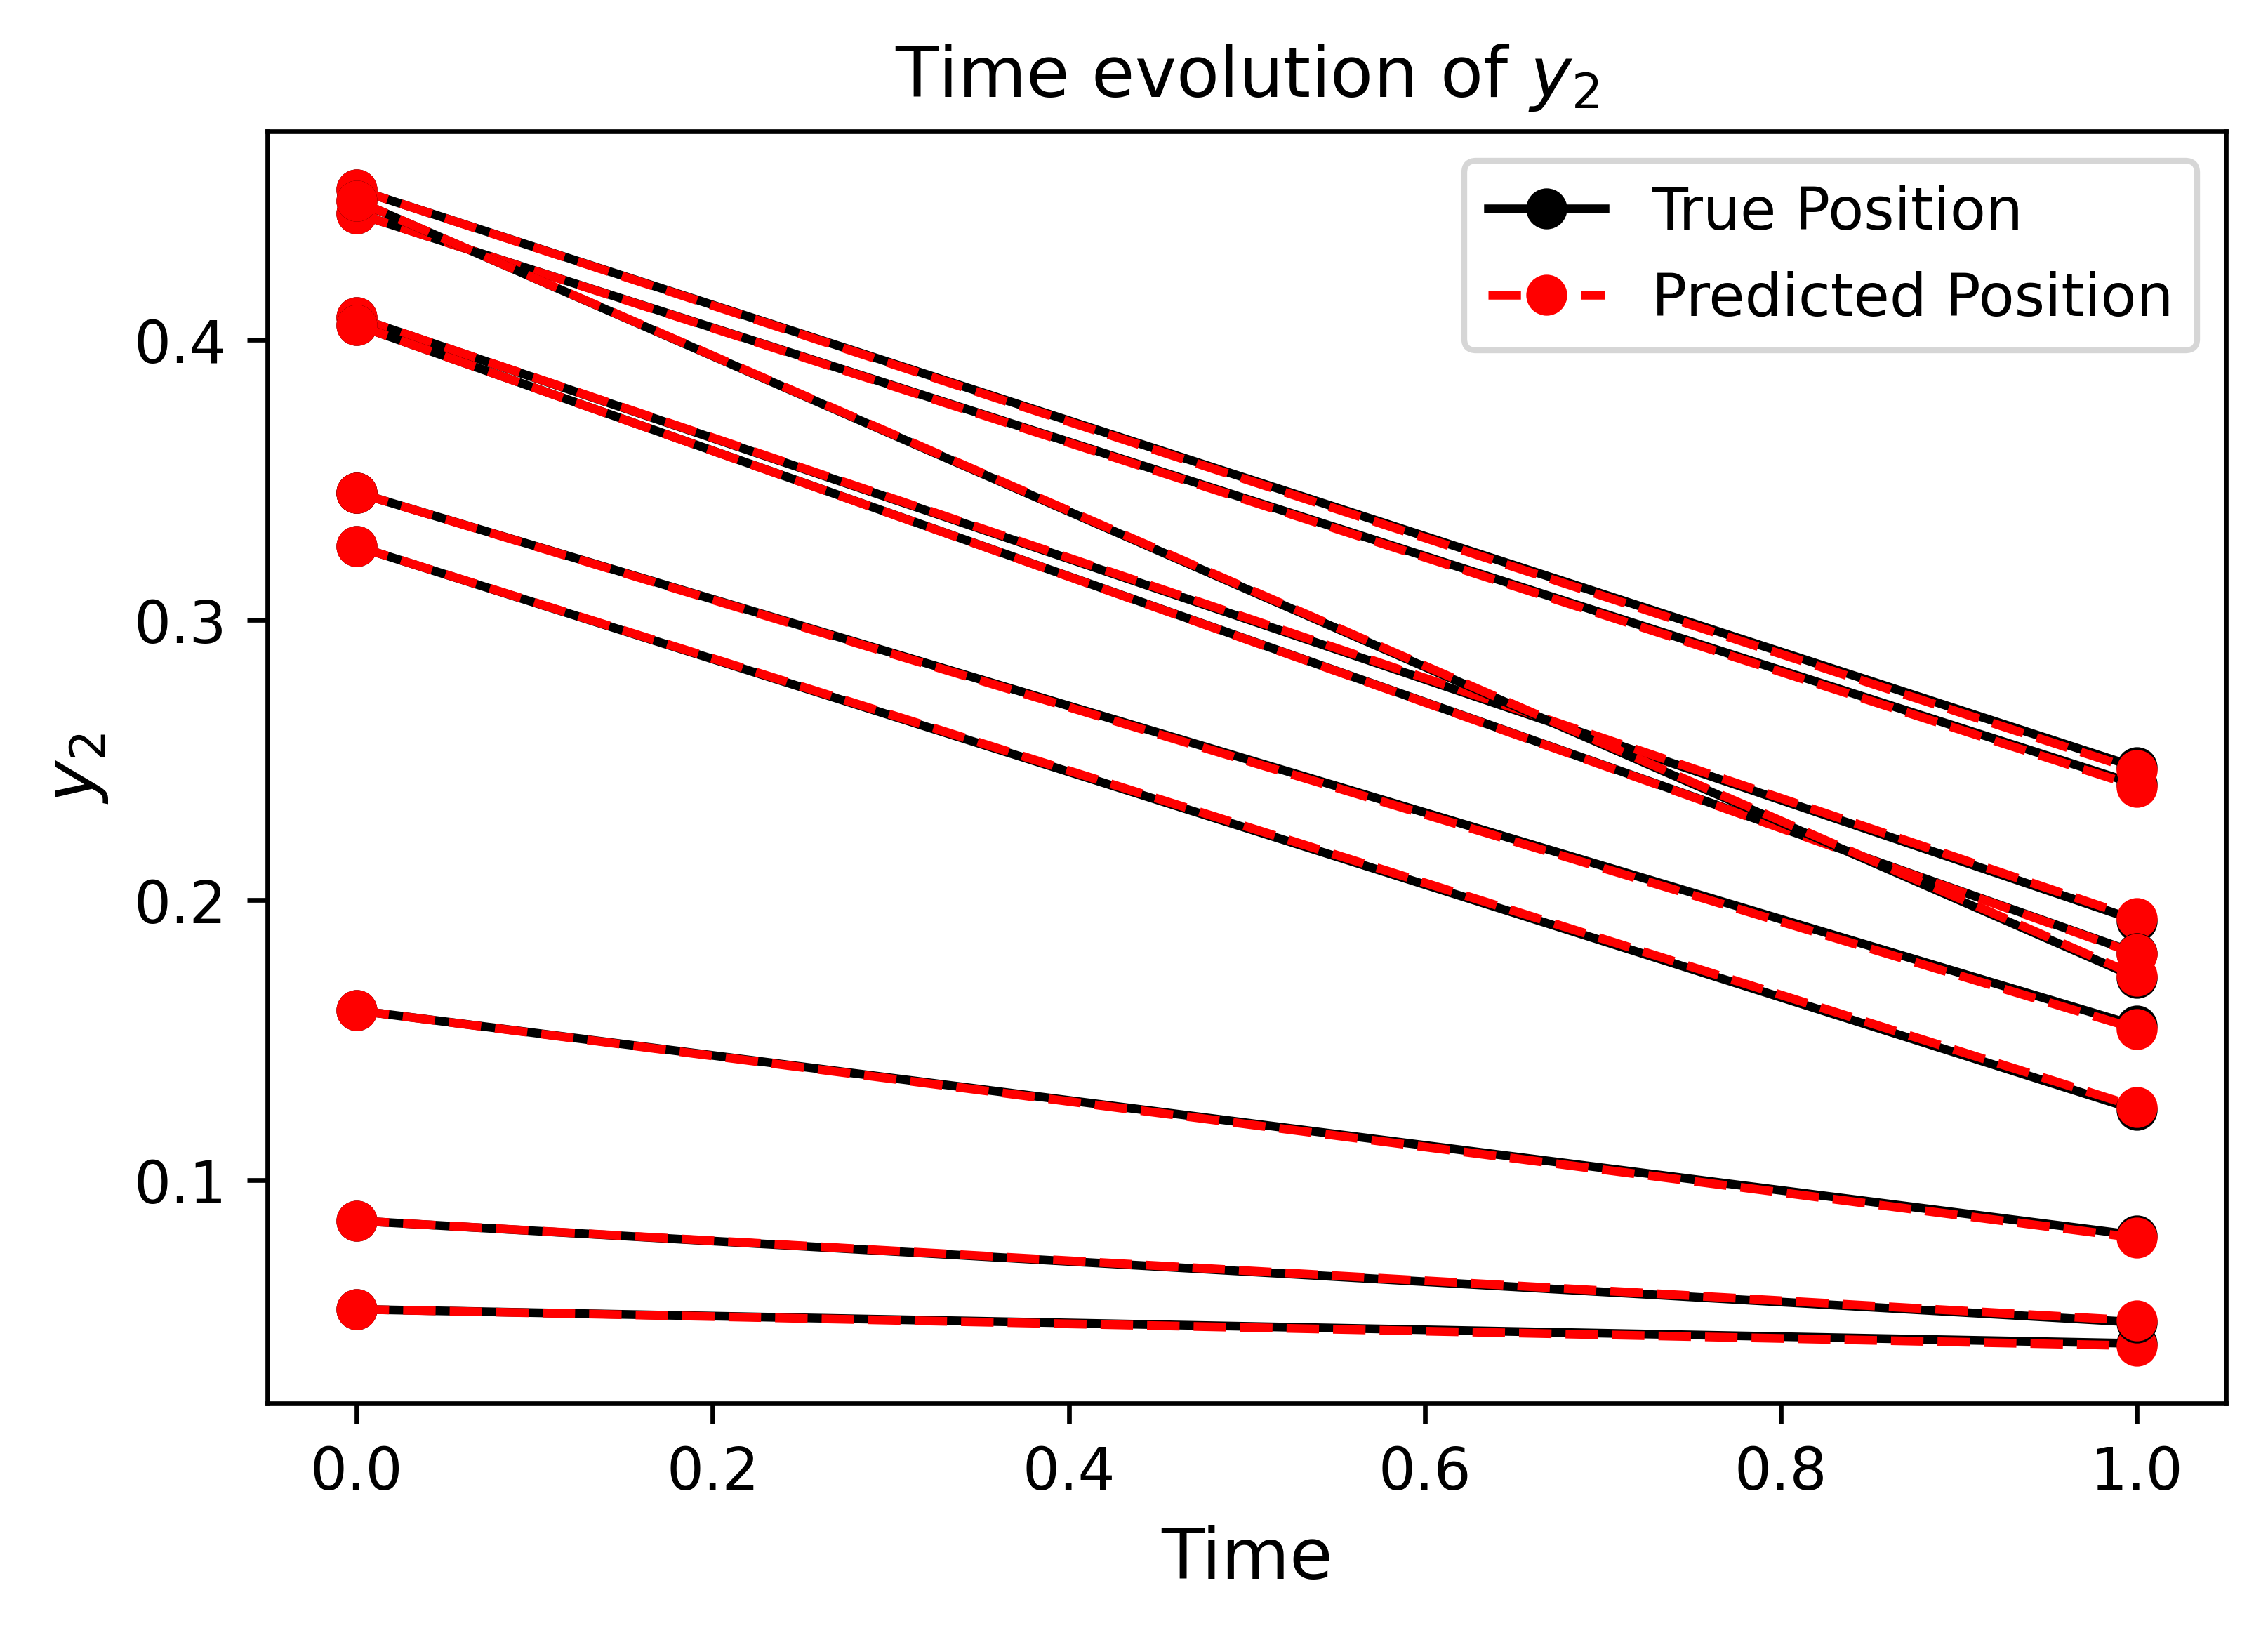

In [23]:
fig = plt.figure(dpi=600)
plt.plot(time[0],sol_true[0,1,0],'k-o',label='True Position')
plt.plot(time[0],sol_predC[0,1,0],'r--o',label='Predicted Position')
for i in range(NN):
    plt.plot(time,sol_true[i,1,:],'k-o')
    plt.plot(time,sol_predC[i,1,:],'r--o')
plt.xlabel("Time",fontsize=12)
plt.ylabel(r"$y_2$",fontsize=12)
plt.legend()
plt.title(r"Time evolution of $y_2$",fontsize=12)
plt.show();

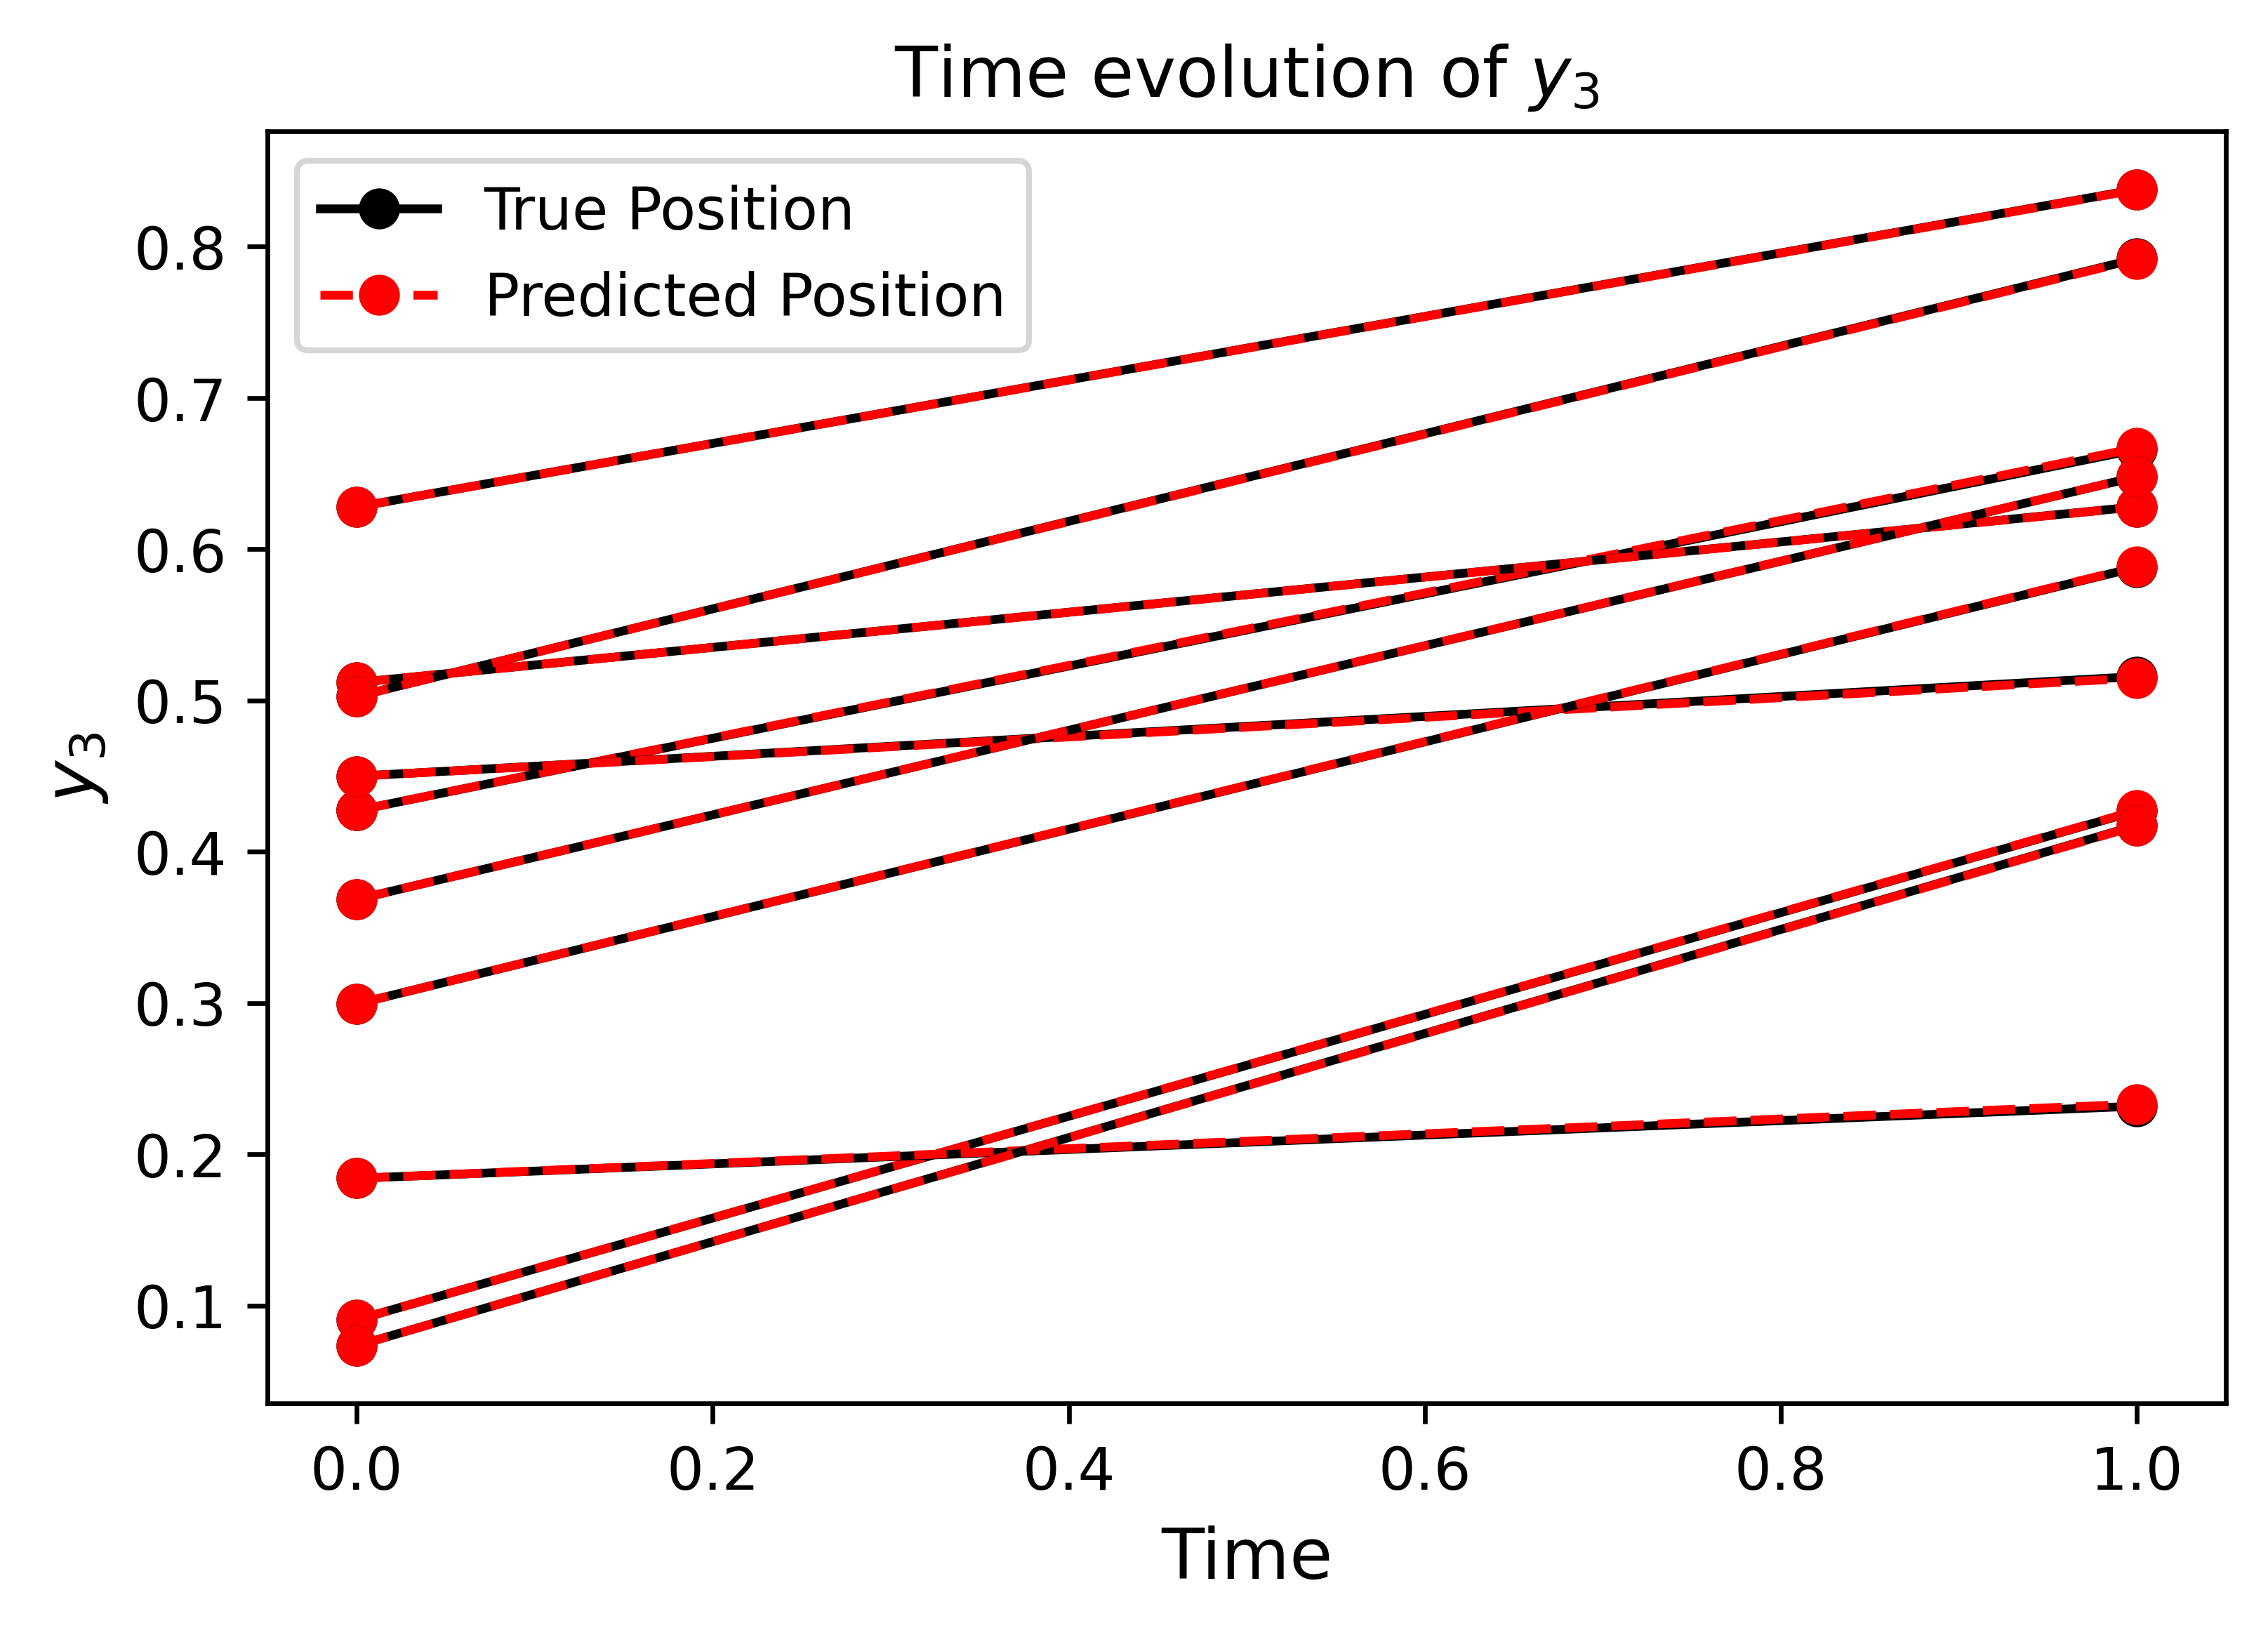

In [24]:
fig = plt.figure(dpi=600)
plt.plot(time[0],sol_true[0,2,0],'k-o',label='True Position')
plt.plot(time[0],sol_predC[0,2,0],'r--o',label='Predicted Position')
for i in range(NN):
    plt.plot(time,sol_true[i,2,:],'k-o')
    plt.plot(time,sol_predC[i,2,:],'r--o')
plt.xlabel("Time",fontsize=12)
plt.ylabel(r"$y_3$",fontsize=12)
plt.legend()
plt.title(r"Time evolution of $y_3$",fontsize=12)
plt.show();